In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:


# Load .mat files
mat_file_pathGT = '/content/drive/MyDrive/Cell-Segmentation/ISBI_dataset/isbi_train_GT.mat'
mat_file_path = '/content/drive/MyDrive/Cell-Segmentation/ISBI_dataset/isbi_train.mat'
mat_contentsGT = scipy.io.loadmat(mat_file_pathGT)
mat_contents = scipy.io.loadmat(mat_file_path)

X = []
Y = []
for i in range(45):
    X.append(mat_contents['ISBI_Train'][i][0])
    Y.append(mat_contentsGT['train_Nuclei'][i][0])

# Prepare data arrays
X = np.array(X)
Y = np.array(Y)

# Ensure the data is in the correct shape
X = X[..., np.newaxis] if X.ndim == 3 else X
Y = Y[..., np.newaxis] if Y.ndim == 3 else Y

# Function to perform diverse image augmentation
def generate_diverse_augmented_images(images, masks, augmentations_per_image=5):
    seed = 42  # Fixed seed for reproducibility
    datagen1 = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='constant',  # Set fill_mode to 'constant'
    cval=230.732177734375  # Set cval to 255 for white fill; use 0 for black
)
    datagen2 = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='constant',  # Set fill_mode to 'constant'
    cval=0  # Set cval to 255 for white fill; use 0 for black
)

    # Generate augmented images and masks
    augmented_images = []
    augmented_masks = []

    # Process each image multiple times with different augmentations
    for i in range(len(images)):
        # Create small batch with the same image to apply different augmentations
        batch_X = np.tile(images[i], (augmentations_per_image, 1, 1, 1))
        batch_Y = np.tile(masks[i], (augmentations_per_image, 1, 1, 1))

        # Create generators for this batch
        image_generator = datagen1.flow(batch_X, batch_size=augmentations_per_image, seed=seed)
        mask_generator = datagen2.flow(batch_Y, batch_size=augmentations_per_image, seed=seed)

        # Generate augmented images and masks
        for _ in range(augmentations_per_image):
            augmented_images.append(next(image_generator)[0])  # Only fetch the first image to avoid repetition
            augmented_masks.append(next(mask_generator)[0])    # Same for masks

    # Combine original and augmented data
    augmented_images = np.concatenate((images, augmented_images))
    augmented_masks = np.concatenate((masks, augmented_masks))

    return augmented_images, augmented_masks

# Apply augmentation
X, Y = generate_diverse_augmented_images(X, Y)


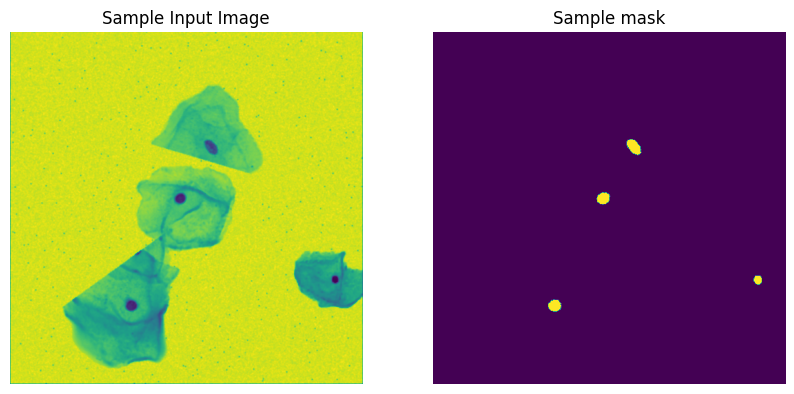

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image on the first axis
axes[0].imshow(X[10])
axes[0].axis('off')  # Hide the axis
axes[0].set_title('Sample Input Image')

# Display the second image on the second axis
axes[1].imshow(Y[10])
axes[1].axis('off')  # Hide the axis
axes[1].set_title('Sample mask')

# Show the plot
plt.show()


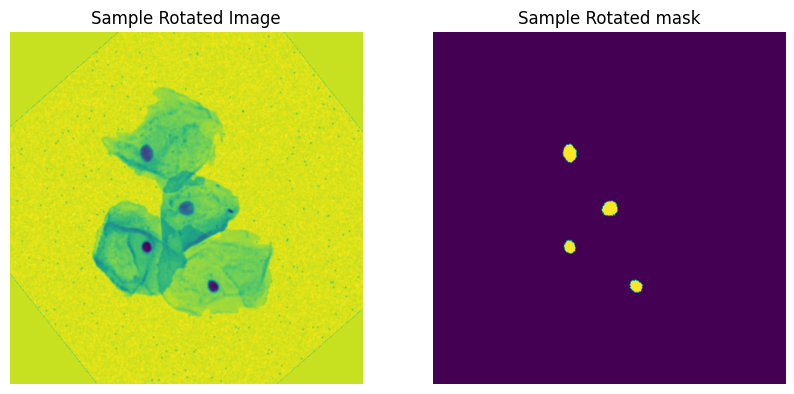

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image on the first axis
axes[0].imshow(X[100])
axes[0].axis('off')  # Hide the axis
axes[0].set_title('Sample Rotated Image')

# Display the second image on the second axis
axes[1].imshow(Y[100])
axes[1].axis('off')  # Hide the axis
axes[1].set_title('Sample Rotated mask')

# Show the plot
plt.show()


In [ ]:
def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=conv10)

    return model

# Define IoU metric
def iou_metric(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / union

model = unet_model(input_size=(X.shape[1], X.shape[2], X.shape[3]))
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[iou_metric])

# Train the model
model.fit(X, Y, validation_split=0.2, epochs=50, batch_size=4)



Epoch 1/50
54/54 [==============================] - 79s 1s/step - loss: 0.0047 - iou_metric: 0.0487 - val_loss: 0.0053 - val_iou_metric: 0.1394
Epoch 2/50
54/54 [==============================] - 55s 1s/step - loss: 0.0031 - iou_metric: 0.1873 - val_loss: 0.0043 - val_iou_metric: 0.2723
Epoch 3/50
54/54 [==============================] - 54s 1s/step - loss: 0.0025 - iou_metric: 0.2700 - val_loss: 0.0041 - val_iou_metric: 0.3107
Epoch 4/50
54/54 [==============================] - 55s 1s/step - loss: 0.0021 - iou_metric: 0.3329 - val_loss: 0.0032 - val_iou_metric: 0.3592
Epoch 5/50
54/54 [==============================] - 55s 1s/step - loss: 0.0015 - iou_metric: 0.5203 - val_loss: 0.0014 - val_iou_metric: 0.7070
Epoch 6/50
54/54 [==============================] - 55s 1s/step - loss: 5.9661e-04 - iou_metric: 0.7330 - val_loss: 0.0012 - val_iou_metric: 0.6934
Epoch 7/50
54/54 [==============================] - 54s 1s/step - loss: 4.2584e-04 - iou_metric: 0.7682 - val_loss: 7.0411e-04 - val

## ****Accuracy Scores For Unet Model****


In [ ]:
# Custom metrics functions
def iou_metric(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return intersection / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

# Load the trained model
model = load_model('/content/drive/MyDrive/Cell-Segmentation/nucleus_segmentation_model.h5', custom_objects={'iou_metric': iou_metric})

# Load test data
mat_test_file_path = '/content/drive/MyDrive/Cell-Segmentation/ISBI_dataset/isbi_test90.mat'
mat_test_contents = scipy.io.loadmat(mat_test_file_path)
mat_test_file_pathGT = '/content/drive/MyDrive/Cell-Segmentation/ISBI_dataset/isbi_test90_GT.mat'
mat_test_contentsGT = scipy.io.loadmat(mat_test_file_pathGT)

X_test = []
Y_test = []
for i in range(5):  # assuming 5 images for demonstration
    X_test.append(mat_test_contents['ISBI_Test90'][i][0])
    Y_test.append(mat_test_contentsGT['test_Nuclei'][i][0])

X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Predict the masks using the model
predicted_masks = model.predict(X_test)

# Calculate IoU, Dice, and Accuracy for each test image
ious = []
dices = []
accuracies = []

for i in range(len(X_test)):
    true_mask = Y_test[i]
    predicted_mask = predicted_masks[i]

    iou = iou_metric(K.variable(true_mask), K.variable(predicted_mask))
    dice = dice_coefficient(K.variable(true_mask), K.variable(predicted_mask))

    # Calculate pixel-wise accuracy
    true_mask_binary = true_mask > 0.5  # assuming binary masks
    predicted_mask_binary = predicted_mask > 0.5
    accuracy = np.mean(true_mask_binary == predicted_mask_binary)

    ious.append(K.eval(iou))
    dices.append(K.eval(dice))
    accuracies.append(accuracy)

# Calculate average metrics
average_iou = np.mean(ious)
average_dice = np.mean(dices)
average_accuracy = np.mean(accuracies)

# Print average metrics
print(f"Average IoU: {average_iou:.4f}")
print(f"Average Dice: {average_dice:.4f}")
print(f"Average Accuracy: {average_accuracy:.4f}")


1/1 [==============================] - 0s 245ms/step
Average IoU: 0.6193
Average Dice: 0.7634
Average Accuracy: 0.9930


## **Save Unet Model to Drive**

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/Cell-Segmentation/nucleus_segmentation_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def iou_metric(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return intersection / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

# Load the trained model
# Load test data
mat_test_file_path = '/content/drive/MyDrive/Cell-Segmentation/ISBI_dataset/isbi_test90.mat'
mat_test_contents = scipy.io.loadmat(mat_test_file_path)
mat_test_file_pathGT = '/content/drive/MyDrive/Cell-Segmentation/ISBI_dataset/isbi_test90_GT.mat'
mat_test_contentsGT = scipy.io.loadmat(mat_test_file_pathGT)

X_test = []
Y_test = []
for i in range(90):  # assuming 90 images
    X_test.append(mat_test_contents['ISBI_Test90'][i][0])
    Y_test.append(mat_test_contentsGT['test_Nuclei'][i][0])

X_test = np.array(X_test)
Y_test = np.array(Y_test)
model = load_model('/content/drive/MyDrive/nucleus_seg_file.h5', custom_objects={'iou_metric': iou_metric})


In [ ]:
predict = model.predict(X_test[80:81])

1/1 [==============================] - 9s 9s/step


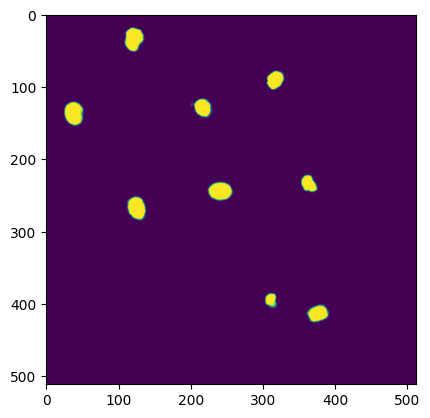

In [ ]:
plt.imshow(predict[0])

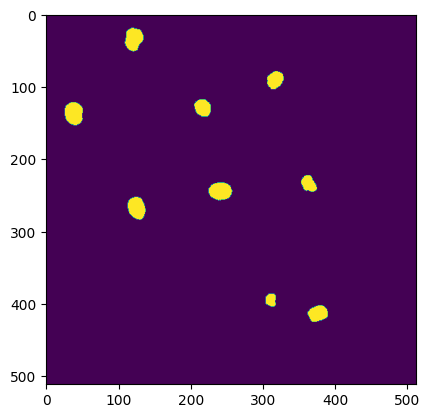

In [ ]:
plt.imshow(predict[0]>0.5)